## MS Example 1: Multiplicative Noise

In [1]:
import numpy as np
import dfo_v1 as dfo
import ECNoise as ECN
import active_subspaces as ac
import matplotlib.pyplot as plt

We choose $\mathbf{x}^{(0)}=(100,0.1,u,u,\ldots,u)$, $u \sim U[-100,100]$.

We let $t: \mathbf{x}: \mathbb{R}^{10} \to \mathbb{R}$, where $t(\mathbf{x})=(x_1^2+x_2^2+x_3^2)(1+ k\epsilon)$, where $\epsilon \sim N(0,1)$ so that $k\epsilon \sim N(0,k^2)$ and $L_1=2$.

In [2]:
dim=10
xinit=2*np.random.rand(dim,1)-1
print(np.shape(xinit))

#my nasty initial condition, but all others will plateau
#xinit[0]=100
#xinit[1]=.1
print(np.transpose(xinit))

(10, 1)
[[ 0.5855157  -0.15680576  0.80705724  0.83335683 -0.16981502 -0.73563419
  -0.25181785 -0.23362434 -0.85026388  0.13054166]]


In [3]:
k=1E-4
def tfun(x,var=k):
    y=np.copy(x)
    return (1E4*np.dot(np.transpose(y[0:3,:]),y[0:3,:])+100)*(1+(k**.5)*np.random.randn(1))
# Print check
print(tfun(xinit))

def tfun2(x,var=k):
    y=np.copy(x)
    return (1E4*np.dot(y[0:3],y[0:3])+100)*(1+(k**.5)*np.random.randn(1))

[[10428.68886426]]


In [4]:
train=60 #of exploratory draws

In [5]:
##Test of Active Subspace with random samples
xp=2*np.random.rand(train,10)-1
fp=np.empty(1)
for v in xp:
    #print(fp.shape)
    #print(tfun2(v))
    fp=np.vstack((fp,tfun2(v)))
fp=np.copy(fp[1:,:])
print(fp.shape)
ss = ac.subspaces.Subspaces()
ss.compute(X=xp, f=fp, nboot=0, sstype='OPG')
sub=ss.eigenvecs[:,0:4]
print(sub)
print(ss.eigenvals)

(60, 1)
n should be an integer. Performing conversion.
[[ 0.42461958  0.00078969  0.49064824  0.14072689]
 [-0.20965942  0.46972134 -0.00696171 -0.3074362 ]
 [-0.63041303 -0.29851596  0.28562785  0.47541846]
 [ 0.15170538  0.20873832  0.34330087  0.24000305]
 [-0.36408494  0.21003292  0.13965843 -0.26600686]
 [ 0.11595402 -0.23186834 -0.56423446  0.1329084 ]
 [-0.14236735  0.37559897 -0.13981008 -0.20676929]
 [-0.35233251  0.21639112 -0.2544663   0.38748716]
 [-0.15502629  0.06096291  0.35807526 -0.152706  ]
 [ 0.20214611  0.59764942 -0.09692386  0.54535447]]
[[41237652.59135856]
 [37610826.90640415]
 [21057334.42129176]
 [14989845.9559398 ]
 [13023713.05935216]
 [10043730.53466972]
 [ 6824003.96005968]
 [ 4484847.40951321]
 [ 2973757.8140487 ]
 [ 2134507.6919504 ]]


In [6]:
#quadratic polynomial approximation
RS = ac.utils.response_surfaces.PolynomialApproximation(2)

print(ss.W1)
#Train the surface with active variable values (y = XX.dot(ss.W1)) and function values (f)
y = xp.dot(ss.W1)
RS.train(y, fp)
print('The R^2 value of the response surface is {:.4f}'.format(RS.Rsqr))

#find minimum over training data
ind=np.argmin(fp)
tmax=fp[ind]
print('minimizer of training data=',tmax)
xstart=np.copy(xp[ind,:])

adim=ss.W1.shape[1]
print(adim)
#indim=dim-adim
x_inact=xstart.dot(ss.eigenvecs[:,adim:])
print('Storing inactive component=',x_inact)                   

#Plot the data and response surface prediction
#plt.figure(figsize=(7, 7))
#y0 = np.linspace(-2, 2, 200)
#plt.plot(y, f, 'bo', y0, RS.predict(y0[:,None])[0], 'k-', linewidth=2, markersize=8)
#plt.grid(True)
#plt.xlabel('Active Variable Value', fontsize=18)
#plt.ylabel('Output', fontsize=18)
avdom = ac.domains.BoundedActiveVariableDomain(ss)

[[ 0.42461958  0.00078969]
 [-0.20965942  0.46972134]
 [-0.63041303 -0.29851596]
 [ 0.15170538  0.20873832]
 [-0.36408494  0.21003292]
 [ 0.11595402 -0.23186834]
 [-0.14236735  0.37559897]
 [-0.35233251  0.21639112]
 [-0.15502629  0.06096291]
 [ 0.20214611  0.59764942]]
The R^2 value of the response surface is 0.3132
minimizer of training data= [671.06093308]
2
Storing inactive component= [-0.69865733  0.44958026  0.35472893 -0.12189901  0.64952176 -0.43135035
 -1.33526159  0.24380586]


In [7]:
#Minimize using the response surface
ystar, fstar = ac.optimizers.av_minimize(lambda x: RS.predict(x.reshape(1,adim))[0], avdom)
print('The response surface optimization results are:',ystar,fstar)


#projection back to full variables
x_act_min=ss.W1@ystar.T
print(x_act_min)
x_inact_min=ss.eigenvecs[:,adim:]@x_inact
xmin=x_act_min+np.reshape(x_inact_min,x_act_min.shape)
print(xmin,'function value at surrogate min',tfun(xmin))

The response surface optimization results are: [[0.21467627 0.10942035]] 7208.750727771747
[[ 0.09124216]
 [ 0.00638817]
 [-0.16799844]
 [ 0.05540776]
 [-0.05517852]
 [-0.00047854]
 [ 0.01053528]
 [-0.05195984]
 [-0.02660988]
 [ 0.10879098]]
[[ 0.06495991]
 [-0.19525683]
 [-0.44746036]
 [-0.89393251]
 [ 0.06506189]
 [ 0.65843377]
 [-0.69011589]
 [ 0.63420849]
 [ 0.580668  ]
 [ 0.80261867]] function value at surrogate min [[2492.62164454]]


In [8]:
M=11 # number of ECNoise f evals

noise_array=ECN.ECNoise(tfun,xinit,M,mult=True)
print(noise_array)
print(xinit)
mynoise=noise_array[0][0]
gen_f_vals=noise_array[2]
print(gen_f_vals, mynoise)

0.08502638819469373
(10, 1) (10, 1)
[array([0.0001771]), array([[ 0.5855157 ,  0.6124034 ,  0.63929111,  0.66617881,  0.69306652,
         0.71995422,  0.74684193,  0.77372963,  0.80061734,  0.82750504,
         0.85439274],
       [-0.15680576, -0.12991806, -0.10303036, -0.07614265, -0.04925495,
        -0.02236724,  0.00452046,  0.03140817,  0.05829587,  0.08518358,
         0.11207128],
       [ 0.80705724,  0.83394495,  0.86083265,  0.88772036,  0.91460806,
         0.94149577,  0.96838347,  0.99527118,  1.02215888,  1.04904659,
         1.07593429],
       [ 0.83335683,  0.86024453,  0.88713224,  0.91401994,  0.94090764,
         0.96779535,  0.99468305,  1.02157076,  1.04845846,  1.07534617,
         1.10223387],
       [-0.16981502, -0.14292732, -0.11603962, -0.08915191, -0.06226421,
        -0.0353765 , -0.0084888 ,  0.01839891,  0.04528661,  0.07217432,
         0.09906202],
       [-0.73563419, -0.70874648, -0.68185878, -0.65497107, -0.62808337,
        -0.60119566, -0.574307

In [9]:
print('estimated noise var is', mynoise, 'true var is', k, 'with relative error', abs(mynoise-k)/k)

estimated noise var is 0.00017710195540983432 true var is 0.0001 with relative error 0.7710195540983431


In [10]:
h=((M-1)//2)*1E-1*np.linalg.norm(xinit,ord=np.inf)
print(h)
print(tfun(xinit))
fl=gen_f_vals[0]
f0=gen_f_vals[(M-1)//2]
fr=gen_f_vals[-1]
print(fl,f0,fr)
L_1_hat=abs(fl-2*f0+fr)*(1/h)**2   #*(1/fm)

d1=abs(fr-f0)*(1/h)
d2=abs(fl-f0)*(1/h)
L_1_hat_1=abs(d1-d2)*(1/(h))   #*(1/fm)


print('estimated upper bound on ||f''|| is', L_1_hat, 'estimated value of L_1 from FD is', L_1_hat_1)

0.4251319409734686
[[10385.86209702]]
10234.236985177717 14336.321979325096 19263.520699367513
estimated upper bound on ||f|| is 4565.2686634079655 estimated value of L_1 from FD is 4565.268663407975


In [11]:
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,dim)
h=dfo.get_h(L_1_hat,dim)

In [12]:
#stars from surrogate min
x=np.copy(xmin)
maxit=50
xhist=np.array(x)
fhist=np.array(tfun(x))
yhist=np.copy(xhist)
ghist=np.copy(fhist)
L1Bhist=np.array(L_1_hat)
for i in range(maxit):
    [x,f,y,fy,p,q,L1B]=dfo.STARS(x,tfun,mu_star,h,mult=True)
    xhist=np.hstack((xhist,x))
    fhist=np.vstack((fhist,f))
    yhist=np.hstack((yhist,y))
    ghist=np.vstack((ghist,fy))
    L1Bhist=np.vstack((L1Bhist,L1B))

In [13]:
print('our algorithm terminates with x value',np.transpose(x), 'which has f value',f)

our algorithm terminates with x value [[-0.00825601  0.00596406 -0.00662889 -0.81618348 -0.0635343   0.48915367
  -0.68784539  0.67677242  0.63354248  0.84266032]] which has f value [[102.12802255]]


In [14]:
### Full Stars, random guess from training set
sind=np.random.randint(train)

notrain_start=np.copy(xp[sind,:])
x=np.copy(notrain_start).reshape((dim,1))
print(x)
maxit=50+30 #give it the training data for free
xhist2=np.array(x)
fhist2=np.array(tfun(x))
yhist2=xhist2
ghist2=fhist2
L1Bhist=np.array(L_1_hat)
for i in range(maxit):
    [x,f,y,fy,p,q,L1B]=dfo.STARS(x,tfun,mu_star,h,mult=True)
    xhist2=np.hstack((xhist2,x))
    fhist2=np.vstack((fhist2,f))
    yhist2=np.hstack((yhist2,y))
    ghist2=np.vstack((ghist2,fy))
    L1Bhist=np.vstack((L1Bhist,L1B))

[[ 0.68071263]
 [-0.7154131 ]
 [ 0.93461374]
 [-0.41267384]
 [-0.71539791]
 [ 0.34228659]
 [ 0.21746996]
 [-0.54635497]
 [ 0.80100623]
 [ 0.12273   ]]


In [15]:
print(xhist.shape,fhist.shape)

(10, 51) (51, 1)


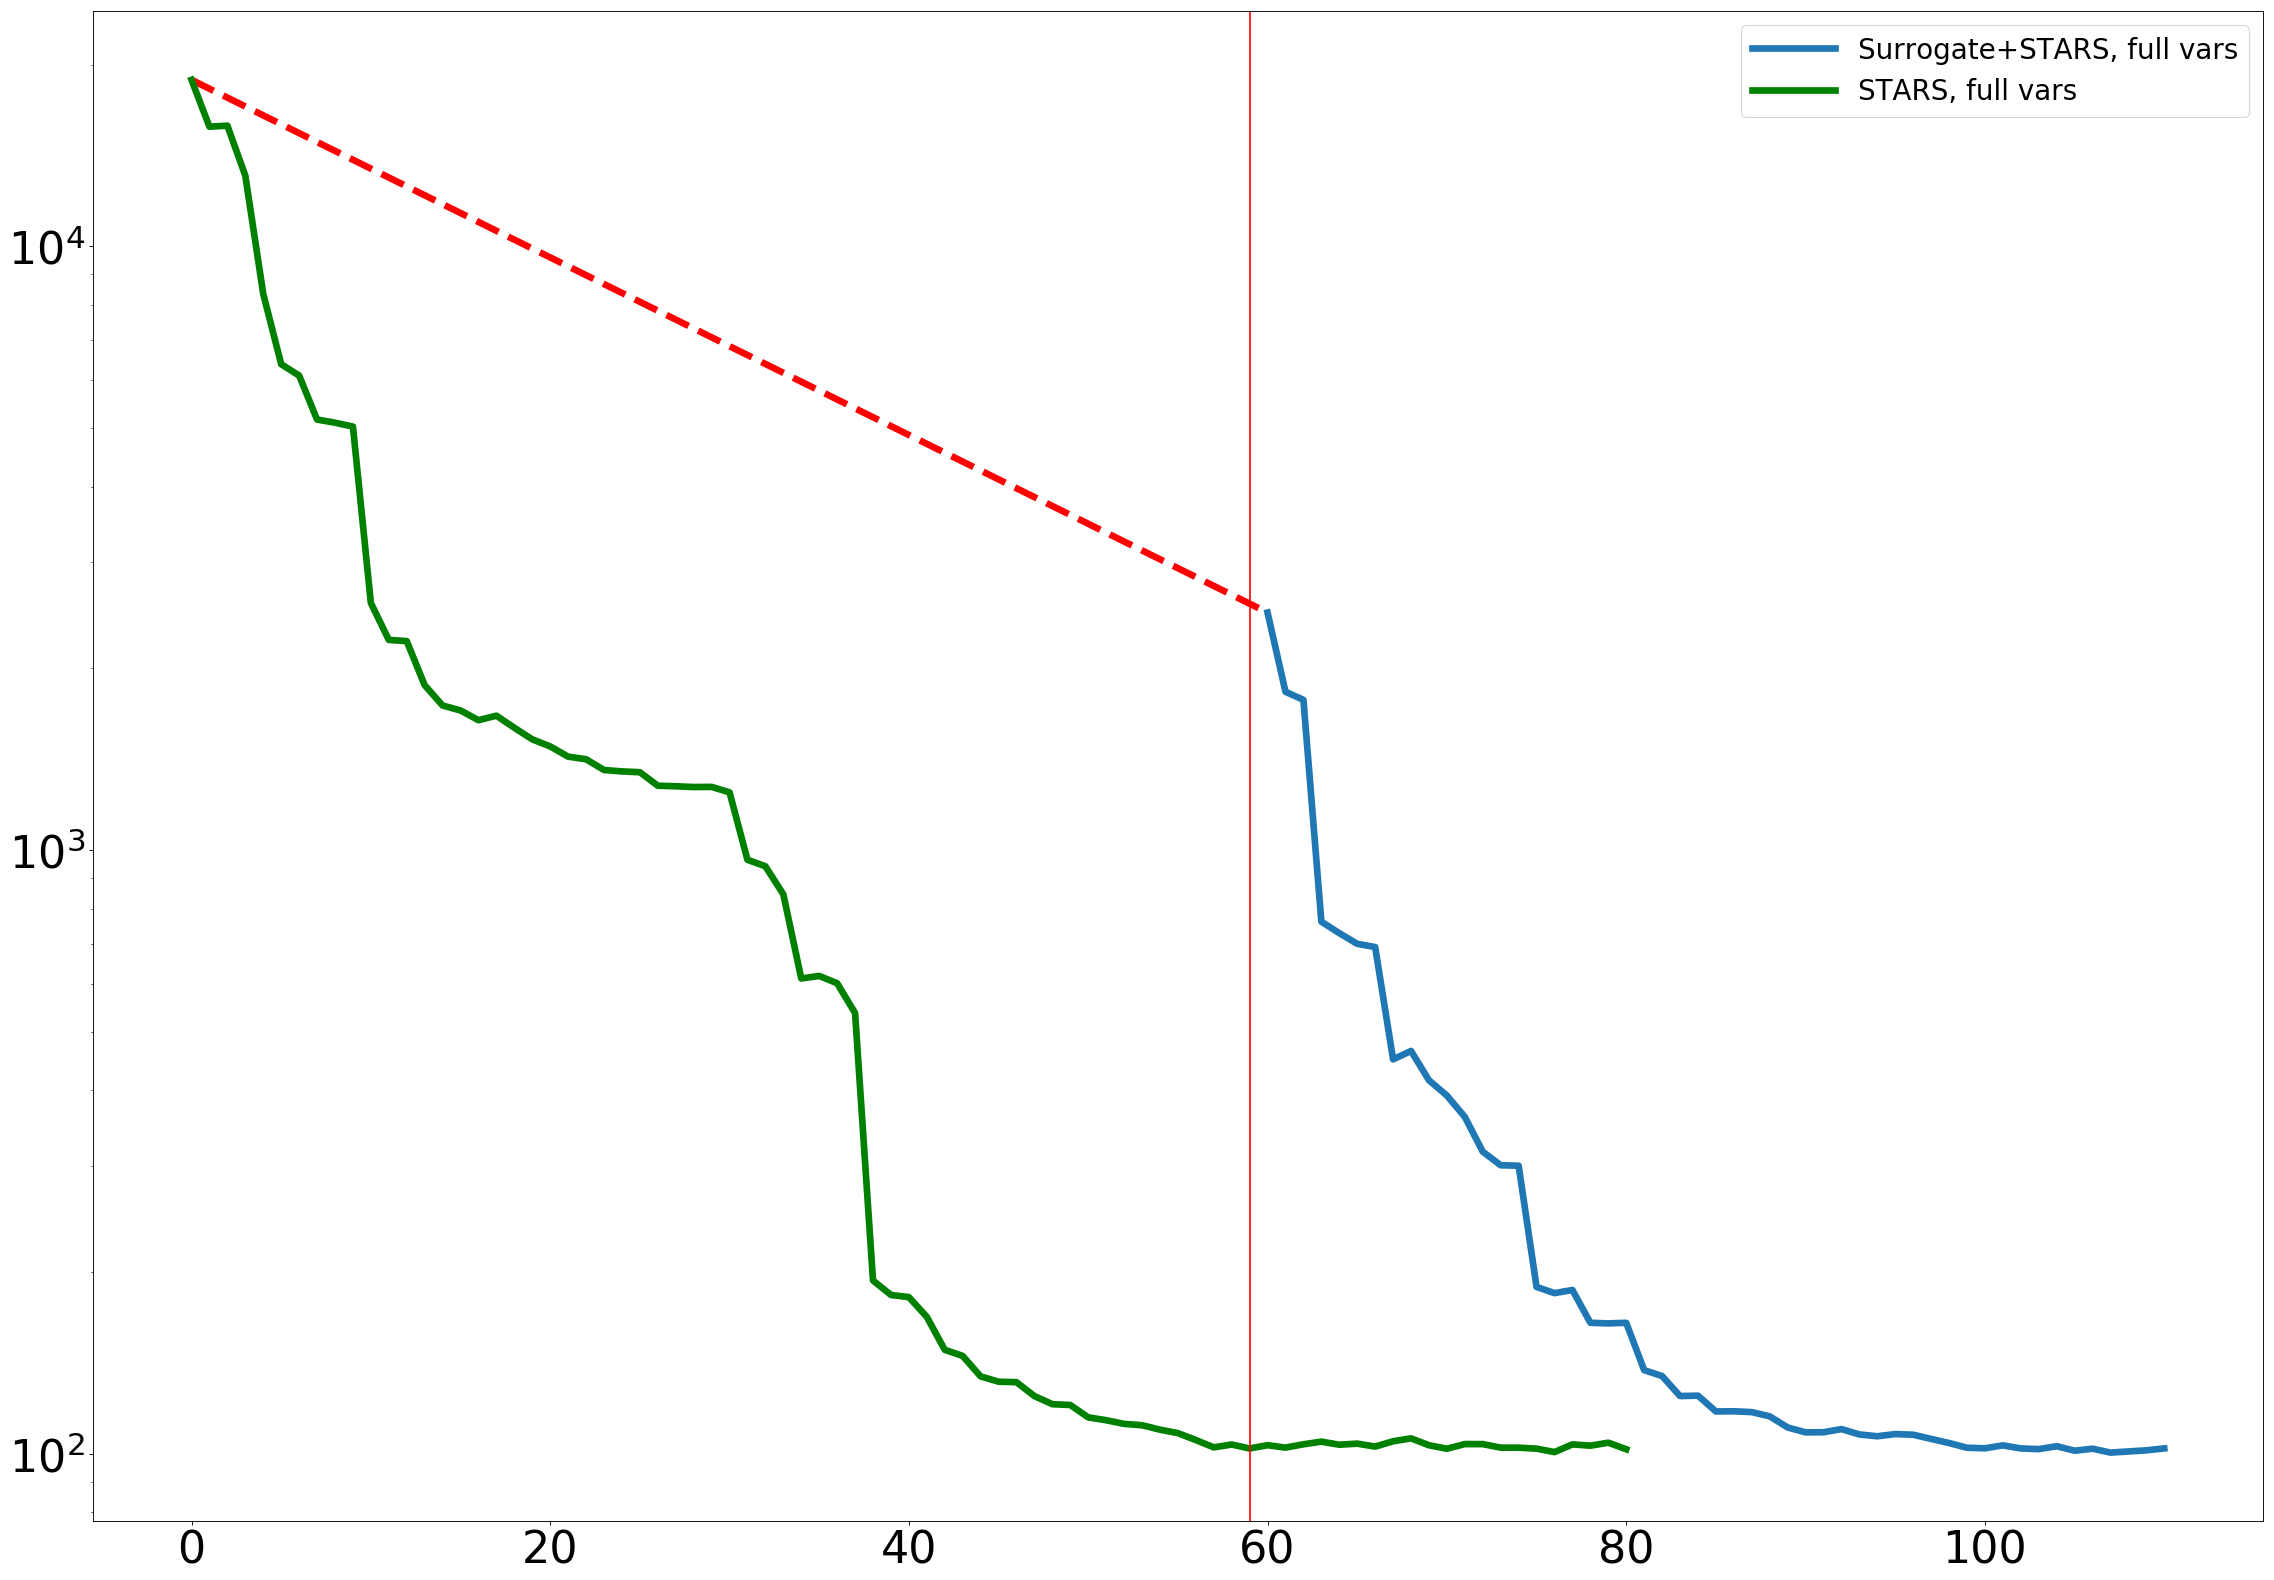

In [16]:
params = {'legend.fontsize': 25,
          'legend.handlelength': 3}
plt.rcParams["figure.figsize"] = (35,25)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 40
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams.update(params)


plt.semilogy([0,train],[fhist2[0],fhist[0]],c='r',ls='--',lw=6)
#plt.axvline(35,)
plt.semilogy(train+np.arange(fhist.size),fhist,lw=6,label='Surrogate+STARS, full vars')
plt.semilogy(fhist2,lw=6,c='g',label='STARS, full vars')
plt.axvline(train-1,c='r')
plt.legend()
plt.show()

In [17]:
#cycles with update every 5 STARS steps
x=np.copy(xmin)
cycles=5
steps=5
xtrain=xp
ftrain=np.copy(fp)
print(ftrain.shape,xtrain.shape)
print(xp.shape,x.shape)
start=train
end=start+steps+1
for loops in range(cycles):
    xhist3=np.copy(x)
    fhist3=np.copy(tfun(x))
    yhist3=np.copy(x)
    ghist3=np.copy(fhist3)
    for i in range(steps):
        [x,f,y,fy,p,q,L1B]=dfo.STARS(x,tfun,mu_star,h,mult=True)
        xhist3=np.hstack((xhist3,x))
        #print(xhist3.shape)
        fhist3=np.vstack((fhist3,f))
        yhist3=np.hstack((yhist3,y))
        ghist3=np.vstack((ghist3,fy))
    plt.semilogy(range(start,end),fhist3)
    
    print('Function value after cycle',loops,'=',f)
    xtrain=np.vstack((xtrain,xhist3.T,yhist3.T[1:,:]))
    ftrain=np.vstack((ftrain,fhist3,ghist3[1:]))
    #train surrogate on added data
    print('Traing with data size',ftrain.size)
    #print(ftrain.shape,xtrain.shape)
    ss.compute(X=xtrain, f=ftrain, nboot=0, sstype='OPG')
    #print(ss.W1)
    #Train the surface with active variable values (y = XX.dot(ss.W1)) and function values (f)
    y = xtrain.dot(ss.W1)
    RS.train(y, ftrain)
    print('The R^2 value of the response surface is {:.4f}'.format(RS.Rsqr))
    #find minimum over training data
    adim=ss.W1.shape[1]
    print('Active variables=',adim)
    #indim=dim-adim
    x_inact=x.T.dot(ss.eigenvecs[:,adim:])
    print('Storing inactive component=',x_inact)                   
    
    avdom = ac.domains.BoundedActiveVariableDomain(ss)
    #Minimize using the response surface
    ystar, fstar = ac.optimizers.av_minimize(lambda x: RS.predict(x.reshape(1,adim))[0], avdom)
    print('The response surface optimization results are:',ystar,fstar)
    #projection back to full variables
    x_act_min=ss.W1@ystar.T
    print(x_act_min)
    x_inact_min=ss.eigenvecs[:,adim:]@x_inact.reshape((dim-adim,1))
    x=x_act_min+np.reshape(x_inact_min,x_act_min.shape)
    print(x,'function value at surrogate min',tfun(x))
    start=end
    end=start+steps+1
plt.show()
    
    

(60, 1) (60, 10)
(60, 10) (10, 1)
Function value after cycle 0 = [[597.97067461]]
Traing with data size 71
n should be an integer. Performing conversion.
The R^2 value of the response surface is 0.0699
Active variables= 1
Storing inactive component= [[-0.8446711   0.12037812 -0.29509383 -0.29453404  0.30669439  0.20298977
   0.09478545  0.43239175  1.37294034]]
The response surface optimization results are: [[-0.34527968]] [[7790.01283402]]
[[-0.10397097]
 [ 0.05749642]
 [-0.17982302]
 [ 0.08279997]
 [ 0.02005835]
 [-0.01745579]
 [ 0.11663982]
 [-0.07779197]
 [ 0.15943582]
 [ 0.14186911]]
[[ 0.0065202 ]
 [-0.0246355 ]
 [-0.28317976]
 [-0.74167681]
 [ 0.0812162 ]
 [ 0.64811649]
 [-0.59045632]
 [ 0.56151188]
 [ 0.68032924]
 [ 1.02607476]] function value at surrogate min [[916.22569541]]
Function value after cycle 1 = [[775.53221161]]
Traing with data size 82
n should be an integer. Performing conversion.
The R^2 value of the response surface is 0.1932
Active variables= 1
Storing inactive

Exception: SLSQP failed with message: Positive directional derivative for linesearch.

In [ ]:
for i in range(10):
    plt.plot(yhist[i])
plt.show()

# OLD STUFF BELOW HERE, IGNORE

## Sing vals weights

In [ ]:
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,6)
h=dfo.get_h(L_1_hat,6)

for tr_stop in range(40,200,10):

    trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,1:tr_stop]))
    trainf=np.vstack((fhist[0:tr_stop],ghist[1:tr_stop]))
    trainx=np.transpose(trainx)


    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

    sub=ss.eigenvecs[:,0:6]
    

    our_wts=np.sqrt(ss.eigenvals)
    print(our_wts)
    x4=np.transpose([xhist[:,tr_stop-1]])
    xhist4=np.array(x4)
    fhist4=np.array(tfun(x4))


    for i in range(0,500-tr_stop):
        [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub, wts=None, mult=True)
        xhist4=np.hstack((xhist4,x4))
        fhist4=np.vstack((fhist4,f))
    plt.semilogy(range(tr_stop,501),fhist4,label='Train '+str(tr_stop),lw=6)


plt.semilogy(fhist, ls=':', lw=6, label='STARS full vars')

plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 1: Learning the AS from STARS iteartes')
plt.legend()
plt.show()

## Equal weights

In [ ]:
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

for tr_stop in range(50,500,50):

    trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
    trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
    trainx=np.transpose(trainx)


    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

    #sub=ss.eigenvecs[:,0:3]
    sub=ss.eigenvecs
    
    our_wts=np.sqrt(ss.eigenvals)
    print(our_wts)
    
    x4=np.transpose([xhist[:,tr_stop-1]])
    xhist4=np.array(x4)
    fhist4=np.array(tfun(x4))


    for i in range(0,500-tr_stop):
        [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub, wts=None, mult=True)
        xhist4=np.hstack((xhist4,x4))
        fhist4=np.vstack((fhist4,f))
    plt.semilogy(range(tr_stop,501),fhist4,label='Train '+str(tr_stop),lw=6)


plt.semilogy(fhist, ls=':', lw=6, label='STARS full vars')

plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 1: Learning the AS from STARS iteartes')
plt.legend()
plt.show()

In [ ]:
plt.plot(yhist[2],lw=6)

In [ ]:
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)


x3=np.copy(xinit)
xhist3=np.array(x3)
fhist3=np.array(tfun(x3))
active=np.eye(dim)
active=np.transpose(active[0:3,:])
eigenvals=np.zeros((dim,1))
for i in range(3):
    eigenvals[i]=1


for i in range(500):
    [x3,f,temp1,temp2, p ,q,L1B]=dfo.STARS(x3,tfun,mu_star,h,active=active,mult=True,wts=eigenvals)
    xhist3=np.hstack((xhist3,x3))
    fhist3=np.vstack((fhist3,f))
    
plt.semilogy(fhist3,lw=6, label='active stars with true active vars')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

tr_stop=100

trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
trainx=np.transpose(trainx)



# Use Global Quadratic
ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

sub=ss.eigenvecs
our_wts=np.sqrt(ss.eigenvals)
print(our_wts)
 
x4=np.transpose([xhist[:,tr_stop-1]])
xhist4=np.array(x4)
fhist5=np.vstack((fhist[0:tr_stop],tfun(x4)))


for i in range(0,500-tr_stop):
    [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub,wts=None, mult=True)
    xhist4=np.hstack((xhist4,x4))
    fhist5=np.vstack((fhist5,f))
    #plt.semilogy(range(tr_stop,301),fhist4,label='Train '+str(tr_stop))


plt.semilogy(fhist5, label='active stars on 100 training points')
plt.legend()
plt.show()

In [ ]:
plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 1: STARS and ASTARS Convergence')

plt.semilogy(fhist, lw=9, label='STARS, full vars with learned hyperparams')
plt.semilogy(fhist3, lw=9, ls=':',  label='Active STARS, true active vars with learned hyperparams')
plt.semilogy(fhist5, lw=9, ls=':',label='Active STARS, learned active vars with learned hyperparams')

plt.legend()
plt.show()